In [64]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [65]:
L = 4 #system size
M = 0.1 #fermion mass
N=3 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [66]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [67]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [68]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [69]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [70]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [71]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [72]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [73]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [74]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [75]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [76]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -7.93219714e-16]


In [77]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [78]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(-0.04768257119706865-0.04991627482285545j)|2 2 0 1>
(0.1077489882933701+0.11279652033250437j)|2 2 0 0>
(-0.19508292893118423-0.20422164428864586j)|2 1 1 1>
(0.05210008467020524+0.054540727972563964j)|2 1 0 1>
(0.04768257119706838+0.04991627482285519j)|2 1 0 0>
(-0.1950829289311786-0.20422164428864745j)|1 1 1 2>
(0.5358665596402176+0.560969381219574j)|1 1 1 1>
(-0.19508292893118118-0.20422164428864928j)|1 1 0 1>
(0.04768257119707209+0.04991627482285389j)|1 0 2 2>
(0.05210008467019989+0.05454072797256378j)|1 0 1 2>
(-0.19508292893117915-0.20422164428864856j)|1 0 1 1>
(0.10774898829337082+0.11279652033250474j)|0 0 2 2>
(-0.0476825711970701-0.04991627482285507j)|0 0 1 2>



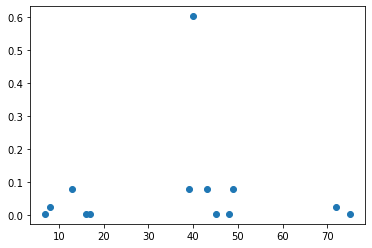

In [79]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [80]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [81]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [82]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [83]:
def R(i,theta):
    
    if i%8 == 0:
        return(ms_gate_global(theta))
    
    if i%8 == 1:
        return(ms_gate_global_1(theta))
    

    if i%8 == 2:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%8 == 3:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%8 == 4:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%8 == 5:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%8 == 6:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%8 == 7:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    
def S(i):
    
    if i%8 == 0:
        return(-1j*matrix_part)
    

    if i%8 == 1:
        return(-1j*matrix_part_1)
    

    if i%8 == 2:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%8 == 3:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%8 == 4:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%8 == 5:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%8 == 6:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%8 == 7:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())



In [40]:
coeff = 8

In [41]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)
    A = []
    B = []
    for k in range(coeff*N):
        A.append(S(k)@R(k,theta[k]))
        B.append(R(k,theta[k]))
        
    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)
    AA = np.einsum("ijk,il->iljk",A,ID)
    BB = np.einsum("ijk,il->iljk",B,ID)
    DD = CC-BB+AA
    dd = []
    for i in range(coeff*N):
        dd.append(reduce(np.dot,DD[i]))
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)
    
    BBB = reduce(np.dot,B)

    DD_d = np.einsum("kij->kji",DD.conj())
    X = np.einsum("m,imn,jnl,l->ij",np.conj(psi_0),DD_d,DD,psi_0)
    Y = np.einsum("m,imn,nl,lk,k->i",np.conj(psi_0),DD_d,full_ham_matrix.toarray(),BBB,psi_0)
    XX = np.einsum("m,imn,nk,k->i",np.conj(psi_0),DD_d,BBB,psi_0)
    YY_1 = np.einsum("m,mn,ink,k->i",np.conj(psi_0),BBB.conj().T,DD,psi_0)
    YY_2 = np.einsum("m,mn,nk,kl,l",np.conj(psi_0),BBB.conj().T,full_ham_matrix.toarray(),BBB,psi_0 )
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    #v = 1e-6*np.exp(-0)*np.ones(coeff*N)
    #v = np.zeros(coeff*N)
    #X = X + np.diag(v)
    print(t)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.imag(Y+YY)

    return np.linalg.pinv(X_r,rcond = 1e-6)@Y_i

In [44]:
stepp = 1000
t_final = 10

In [45]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [46]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [47]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
import datetime
print(datetime.datetime.now())
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)
print(datetime.datetime.now())

2022-07-18 14:48:21.439908
0
0.005
0.005
0.01
0.01
0.015
0.015
0.02
0.02
0.025
0.025
0.03
0.03
0.034999999999999996
0.034999999999999996
0.04
0.04
0.045
0.045
0.05
0.05
0.055
0.055
0.060000000000000005
0.060000000000000005
0.065
0.065
0.07
0.07
0.07500000000000001
0.07500000000000001
0.08
0.08
0.085
0.085
0.09
0.09
0.095
0.095
0.09999999999999999
0.09999999999999999
0.105
0.105
0.10999999999999999
0.10999999999999999
0.11499999999999999
0.11499999999999999
0.11999999999999998
0.11999999999999998
0.12499999999999999
0.12499999999999999
0.12999999999999998
0.12999999999999998
0.13499999999999998
0.13499999999999998
0.13999999999999999
0.13999999999999999
0.145
0.145
0.15
0.15
0.155
0.155
0.16
0.16
0.165
0.165
0.17
0.17
0.17500000000000002
0.17500000000000002
0.18000000000000002
0.18000000000000002
0.18500000000000003
0.18500000000000003
0.19000000000000003
0.19000000000000003
0.19500000000000003
0.19500000000000003
0.20000000000000004
0.20000000000000004
0.20500000000000004
0.20500000000

1.1450000000000007
1.1500000000000008
1.1500000000000008
1.1550000000000007
1.1550000000000007
1.1600000000000008
1.1600000000000008
1.1650000000000007
1.1650000000000007
1.1700000000000008
1.1700000000000008
1.1750000000000007
1.1750000000000007
1.1800000000000008
1.1800000000000008
1.1850000000000007
1.1850000000000007
1.1900000000000008
1.1900000000000008
1.1950000000000007
1.1950000000000007
1.2000000000000008
1.2000000000000008
1.2050000000000007
1.2050000000000007
1.2100000000000009
1.2100000000000009
1.2150000000000007
1.2150000000000007
1.2200000000000009
1.2200000000000009
1.2250000000000008
1.2250000000000008
1.2300000000000009
1.2300000000000009
1.2350000000000008
1.2350000000000008
1.2400000000000009
1.2400000000000009
1.2450000000000008
1.2450000000000008
1.2500000000000009
1.2500000000000009
1.2550000000000008
1.2550000000000008
1.260000000000001
1.260000000000001
1.2650000000000008
1.2650000000000008
1.270000000000001
1.270000000000001
1.2750000000000008
1.27500000000000

2.259999999999996
2.259999999999996
2.2649999999999957
2.2649999999999957
2.2699999999999956
2.2699999999999956
2.2749999999999955
2.2749999999999955
2.2799999999999954
2.2799999999999954
2.2849999999999953
2.2849999999999953
2.289999999999995
2.289999999999995
2.294999999999995
2.294999999999995
2.299999999999995
2.299999999999995
2.304999999999995
2.304999999999995
2.3099999999999947
2.3099999999999947
2.3149999999999946
2.3149999999999946
2.3199999999999945
2.3199999999999945
2.3249999999999944
2.3249999999999944
2.3299999999999943
2.3299999999999943
2.334999999999994
2.334999999999994
2.339999999999994
2.339999999999994
2.344999999999994
2.344999999999994
2.349999999999994
2.349999999999994
2.3549999999999938
2.3549999999999938
2.3599999999999937
2.3599999999999937
2.3649999999999936
2.3649999999999936
2.3699999999999934
2.3699999999999934
2.3749999999999933
2.3749999999999933
2.3799999999999932
2.3799999999999932
2.384999999999993
2.384999999999993
2.389999999999993
2.389999999999

3.3649999999999722
3.369999999999972
3.369999999999972
3.374999999999972
3.374999999999972
3.379999999999972
3.379999999999972
3.384999999999972
3.384999999999972
3.3899999999999717
3.3899999999999717
3.3949999999999716
3.3949999999999716
3.3999999999999715
3.3999999999999715
3.4049999999999714
3.4049999999999714
3.4099999999999713
3.4099999999999713
3.414999999999971
3.414999999999971
3.419999999999971
3.419999999999971
3.424999999999971
3.424999999999971
3.429999999999971
3.429999999999971
3.4349999999999707
3.4349999999999707
3.4399999999999706
3.4399999999999706
3.4449999999999705
3.4449999999999705
3.4499999999999704
3.4499999999999704
3.4549999999999703
3.4549999999999703
3.45999999999997
3.45999999999997
3.46499999999997
3.46499999999997
3.46999999999997
3.46999999999997
3.47499999999997
3.47499999999997
3.47999999999997
3.47999999999997
3.4849999999999697
3.4849999999999697
3.4899999999999696
3.4899999999999696
3.4949999999999695
3.4949999999999695
3.4999999999999694
3.49999999

4.489999999999949
4.489999999999949
4.494999999999949
4.494999999999949
4.4999999999999485
4.4999999999999485
4.504999999999948
4.504999999999948
4.509999999999948
4.509999999999948
4.514999999999948
4.514999999999948
4.519999999999948
4.519999999999948
4.524999999999948
4.524999999999948
4.529999999999948
4.529999999999948
4.534999999999948
4.534999999999948
4.539999999999948
4.539999999999948
4.5449999999999475
4.5449999999999475
4.549999999999947
4.549999999999947
4.554999999999947
4.554999999999947
4.559999999999947
4.559999999999947
4.564999999999947
4.564999999999947
4.569999999999947
4.569999999999947
4.574999999999947
4.574999999999947
4.579999999999947
4.579999999999947
4.584999999999947
4.584999999999947
4.589999999999947
4.589999999999947
4.5949999999999465
4.5949999999999465
4.599999999999946
4.599999999999946
4.604999999999946
4.604999999999946
4.609999999999946
4.609999999999946
4.614999999999946
4.614999999999946
4.619999999999946
4.619999999999946
4.624999999999946
4.62

5.6249999999999245
5.629999999999924
5.629999999999924
5.634999999999924
5.634999999999924
5.639999999999924
5.639999999999924
5.644999999999924
5.644999999999924
5.649999999999924
5.649999999999924
5.654999999999924
5.654999999999924
5.659999999999924
5.659999999999924
5.664999999999924
5.664999999999924
5.6699999999999235
5.6699999999999235
5.674999999999923
5.674999999999923
5.679999999999923
5.679999999999923
5.684999999999923
5.684999999999923
5.689999999999923
5.689999999999923
5.694999999999923
5.694999999999923
5.699999999999923
5.699999999999923
5.704999999999923
5.704999999999923
5.709999999999923
5.709999999999923
5.714999999999923
5.714999999999923
5.7199999999999225
5.7199999999999225
5.724999999999922
5.724999999999922
5.729999999999922
5.729999999999922
5.734999999999922
5.734999999999922
5.739999999999922
5.739999999999922
5.744999999999922
5.744999999999922
5.749999999999922
5.749999999999922
5.754999999999922
5.754999999999922
5.759999999999922
5.759999999999922
5.764

6.7649999999999
6.7649999999999
6.7699999999999
6.7699999999999
6.7749999999999
6.7749999999999
6.7799999999999
6.7799999999999
6.7849999999999
6.7849999999999
6.7899999999999
6.7899999999999
6.7949999999999
6.7949999999999
6.7999999999998995
6.7999999999998995
6.804999999999899
6.804999999999899
6.809999999999899
6.809999999999899
6.814999999999899
6.814999999999899
6.819999999999899
6.819999999999899
6.824999999999899
6.824999999999899
6.829999999999899
6.829999999999899
6.834999999999899
6.834999999999899
6.839999999999899
6.839999999999899
6.8449999999998985
6.8449999999998985
6.849999999999898
6.849999999999898
6.854999999999898
6.854999999999898
6.859999999999898
6.859999999999898
6.864999999999898
6.864999999999898
6.869999999999898
6.869999999999898
6.874999999999898
6.874999999999898
6.879999999999898
6.879999999999898
6.884999999999898
6.884999999999898
6.8899999999998975
6.8899999999998975
6.894999999999897
6.894999999999897
6.899999999999897
6.899999999999897
6.904999999999

7.904999999999876
7.904999999999876
7.909999999999876
7.909999999999876
7.914999999999876
7.914999999999876
7.919999999999876
7.919999999999876
7.9249999999998755
7.9249999999998755
7.929999999999875
7.929999999999875
7.934999999999875
7.934999999999875
7.939999999999875
7.939999999999875
7.944999999999875
7.944999999999875
7.949999999999875
7.949999999999875
7.954999999999875
7.954999999999875
7.959999999999875
7.959999999999875
7.964999999999875
7.964999999999875
7.9699999999998745
7.9699999999998745
7.974999999999874
7.974999999999874
7.979999999999874
7.979999999999874
7.984999999999874
7.984999999999874
7.989999999999874
7.989999999999874
7.994999999999874
7.994999999999874
7.999999999999874
7.999999999999874
8.004999999999875
8.004999999999875
8.009999999999874
8.009999999999874
8.014999999999874
8.014999999999874
8.019999999999873
8.019999999999873
8.024999999999874
8.024999999999874
8.029999999999873
8.029999999999873
8.034999999999874
8.034999999999874
8.039999999999873
8.0399

9.049999999999851
9.054999999999852
9.054999999999852
9.059999999999851
9.059999999999851
9.064999999999852
9.064999999999852
9.069999999999851
9.069999999999851
9.074999999999852
9.074999999999852
9.07999999999985
9.07999999999985
9.084999999999852
9.084999999999852
9.08999999999985
9.08999999999985
9.094999999999851
9.094999999999851
9.09999999999985
9.09999999999985
9.104999999999851
9.104999999999851
9.10999999999985
9.10999999999985
9.114999999999851
9.114999999999851
9.11999999999985
9.11999999999985
9.12499999999985
9.12499999999985
9.12999999999985
9.12999999999985
9.13499999999985
9.13499999999985
9.13999999999985
9.13999999999985
9.14499999999985
9.14499999999985
9.14999999999985
9.14999999999985
9.15499999999985
9.15499999999985
9.15999999999985
9.15999999999985
9.16499999999985
9.16499999999985
9.169999999999849
9.169999999999849
9.17499999999985
9.17499999999985
9.179999999999849
9.179999999999849
9.18499999999985
9.18499999999985
9.189999999999849
9.189999999999849
9.1949

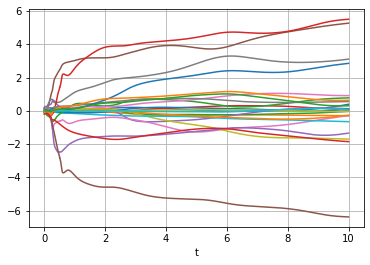

In [48]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [57]:
obs = [[1.,2]]
obs_1 = [[-1.,0]]


obs_map = [
            ["z", obs], 
            #["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(LL+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [58]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [59]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [60]:
psi = var_ansatz(start_point,psi_0)

In [61]:
psi_ground = eigenvec[:,0]


In [62]:
expt_value_u = np.zeros(len(time_domain))
expt_value_v = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(LL+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.real(np.conj(psi_var)@observable_matrix@psi_var)/norm**2
    expt_value_v[tt] = np.real(np.conj(hamiltonian_evolution(time_domain[tt])@psi)@observable_matrix@hamiltonian_evolution(time_domain[tt])@psi)


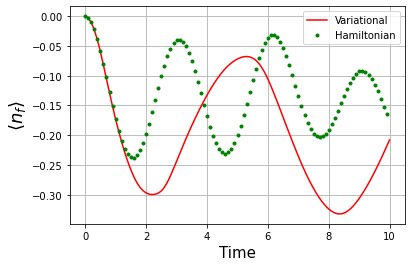

In [63]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")
plt.plot(time_domain[::10],expt_value_v[::10],".",color = "green",label = "Hamiltonian")

plt.ylabel(r"$\langle n_f\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(10,20)
#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")